<a href="https://colab.research.google.com/github/DK45P3R/TCC2024/blob/main/Scripts/MLP_Treino_Grafico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelo MLP


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback
import csv

In [2]:
df = pd.read_csv('api_calls_2b.csv')
print(df)

     Nome do Arquivo;android.support.v7.widget.ActionMenuView.getOverflowIcon;android.view.View.getWindowVisibleDisplayFrame;java.util.Collections.synchronizedList;android.widget.ImageButton.getDrawable;android.support.v4.view.ViewPager.addOnAdapterChangeListener;android.content.SharedPreferences;java.lang.Runnable;android.content.Context.getCodeCacheDir;android.database.Cursor.moveToPosition;android.content.IntentFilter;android.widget.TabWidget;android.app.Fragment.getActivity;java.lang.Math.pow;android.os.ConditionVariable;android.support.v7.app.NotificationCompat;android.view.View.restoreDefaultFocus;android.content.Context.getSharedPreferences;android.support.v7.widget.ListViewCompat.setSelectorEnabled;android.support.v4.content.pm.ShortcutInfoCompat.access$600;android.view.SurfaceHolder;android.support.v4.view.ViewPager.getWidth;android.widget.TextView.setHintTextColor;android.view.View.setLayerType;android.support.v7.widget.SearchView.forceSuggestionQuery;java.io.PrintWriter;andr

API Calls

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback
import csv

# Função de callback para imprimir informações sobre o número de amostras
def on_epoch_end(epoch, logs):
    print(f"\nÉpoca {epoch + 1}:")
    print(f"Número de amostras no treino: {X_train.shape[0]}")
    print(f"Número de amostras no teste: {X_test.shape[0]}")

# Carregar dados dos arquivos CSV com número máximo de campos
csv_file_benign = 'api_calls_2b.csv'
csv_file_malign = 'api_calls_2m.csv'

# Determinar o número máximo de colunas entre os arquivos
num_cols_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
num_cols_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
max_num_cols = max(num_cols_benign, num_cols_malign)

# Carregar os dados com o número máximo de colunas, preenchendo faltantes com NaN
data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
data_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')

# Adicionar coluna de classe ("benigno" ou "maligno")
data_benign['classe'] = 'benigno'
data_malign['classe'] = 'maligno'

# Remover a coluna "Nome do Arquivo" de cada dataset, caso exista
if 'Nome do Arquivo' in data_benign.columns:
    data_benign = data_benign.drop(columns=['Nome do Arquivo'])
if 'Nome do Arquivo' in data_malign.columns:
    data_malign = data_malign.drop(columns=['Nome do Arquivo'])

# Realizar undersampling nos dados benignos para igualar o número de amostras malignas
data_benign_downsampled = resample(data_benign, replace=False, n_samples=len(data_malign), random_state=42)

# Concatenar os datasets balanceados
data_full = pd.concat([data_benign_downsampled, data_malign], axis=0)

# Separar entradas (X) e rótulos (y) do dataset
X = data_full.iloc[:, :-1]  # Excluir a última coluna (classe)
y = data_full.iloc[:, -1]   # Última coluna, que contém as classes

# Converter colunas para numéricas e preencher valores faltantes com 0.0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Normalizar valores
X = X.applymap(lambda x: 1 if x > 300 else 0)

# Converter rótulos de texto para valores binários: benigno = 0, maligno = 1
y = y.replace({'benigno': 0, 'maligno': 1}).astype(np.int32)

# Garantir que os dados estejam no formato correto
X = X.astype(np.float32)
y = y.astype(np.int32)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter rótulos para formato categórico (detecção binária)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Criar e compilar o modelo MLP
model = Sequential()
model.add(Dense(1024, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definir o callback e treinar o modelo
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[print_callback])

# Avaliação e relatório
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

report = classification_report(y_test_classes, y_pred_classes, target_names=['benigno', 'maligno'])
print("\nRelatório de Classificação:\n", report)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusão:\n", conf_matrix)

# Salvar o modelo
model.save('MLP_API.h5')
print("Modelo salvo como 'MLP_API.h5'")


<ipython-input-3-7d031d5f116c>:28: ParserWarning: Skipping line 24: expected 5832 fields, saw 6408
Skipping line 34: expected 5832 fields, saw 6695
Skipping line 51: expected 5832 fields, saw 6473
Skipping line 59: expected 5832 fields, saw 7106
Skipping line 88: expected 5832 fields, saw 6695
Skipping line 89: expected 5832 fields, saw 6002
Skipping line 99: expected 5832 fields, saw 5901
Skipping line 108: expected 5832 fields, saw 6002
Skipping line 112: expected 5832 fields, saw 6121
Skipping line 119: expected 5832 fields, saw 6060
Skipping line 126: expected 5832 fields, saw 6277
Skipping line 133: expected 5832 fields, saw 7420

  data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
<ipython-input-3-7d031d5f116c>:28: ParserWarning: Skipping line 160: expected 5832 fields, saw 6523
Skipping line 174: expected 5832 fields, saw 5854
Skipping line 175: expected 5832 fields, saw 6475
Skippin

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4968 - loss: 1.6805
Época 1:
Número de amostras no treino: 1564
Número de amostras no teste: 392
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.4978 - loss: 1.6679 - val_accuracy: 0.6480 - val_loss: 0.6193
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7456 - loss: 0.5580
Época 2:
Número de amostras no treino: 1564
Número de amostras no teste: 392
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.7460 - loss: 0.5574 - val_accuracy: 0.6964 - val_loss: 0.5573
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8246 - loss: 0.4318
Época 3:
Número de amostras no treino: 1564
Número de amostras no teste: 392
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.8244 - loss: 0.4318 - val_accuracy: 0.7474 - val_loss: 0.5489
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8716 - loss: 0.3288
Época 4:
Número de amostras no treino: 1564
Número de amostras no teste: 


Relatório de Classificação:
               precision    recall  f1-score   support

     benigno       0.81      0.58      0.68       201
     maligno       0.66      0.85      0.74       191

    accuracy                           0.71       392
   macro avg       0.73      0.72      0.71       392
weighted avg       0.74      0.71      0.71       392

Matriz de Confusão:
 [[117  84]
 [ 28 163]]
Modelo salvo como 'MLP_API.h5'


OPCodes

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback
import csv

# Função de callback para imprimir informações sobre o número de amostras
def on_epoch_end(epoch, logs):
    print(f"\nÉpoca {epoch + 1}:")
    print(f"Número de amostras no treino: {X_train.shape[0]}")
    print(f"Número de amostras no teste: {X_test.shape[0]}")

# Carregar dados dos arquivos CSV com número máximo de campos
csv_file_benign = 'opcodes_2b.csv'
csv_file_malign = 'opcodes_2m.csv'

# Determinar o número máximo de colunas entre os arquivos
num_cols_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
num_cols_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
max_num_cols = max(num_cols_benign, num_cols_malign)

# Carregar os dados com o número máximo de colunas, preenchendo faltantes com NaN
data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
data_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')

# Adicionar coluna de classe ("benigno" ou "maligno")
data_benign['classe'] = 'benigno'
data_malign['classe'] = 'maligno'

# Remover a coluna "Nome do Arquivo" de cada dataset, caso exista
if 'Nome do Arquivo' in data_benign.columns:
    data_benign = data_benign.drop(columns=['Nome do Arquivo'])
if 'Nome do Arquivo' in data_malign.columns:
    data_malign = data_malign.drop(columns=['Nome do Arquivo'])

# Realizar undersampling nos dados benignos para igualar o número de amostras malignas
data_benign_downsampled = resample(data_benign, replace=False, n_samples=len(data_malign), random_state=42)

# Concatenar os datasets balanceados
data_full = pd.concat([data_benign_downsampled, data_malign], axis=0)

# Separar entradas (X) e rótulos (y) do dataset
X = data_full.iloc[:, :-1]  # Excluir a última coluna (classe)
y = data_full.iloc[:, -1]   # Última coluna, que contém as classes

# Converter colunas para numéricas e preencher valores faltantes com 0.0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Normalizar valores: <= 50 -> 0, > 50 -> 1
X = X.applymap(lambda x: 1 if x > 1250 else 0)

# Converter rótulos de texto para valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Garantir que os dados estejam no formato correto
X = X.astype(np.float32)
y = y.astype(np.int32)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter rótulos para formato categórico (detecção binária)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Criar e compilar o modelo MLP
model = Sequential()
model.add(Dense(1024, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definir o callback e treinar o modelo
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X_train, y_train, batch_size=32, epochs=125, validation_data=(X_test, y_test), callbacks=[print_callback])

# Avaliação e relatório
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

report = classification_report(y_test_classes, y_pred_classes, target_names=['benigno', 'maligno'])
print("\nRelatório de Classificação:\n", report)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusão:\n", conf_matrix)

# Salvar o modelo
model.save('MLP_Op.h5')
print("Modelo salvo como 'MLP_Op.h5'")


<ipython-input-4-c2ede5c30c62>:28: ParserWarning: Skipping line 9: expected 197 fields, saw 200
Skipping line 10: expected 197 fields, saw 207
Skipping line 14: expected 197 fields, saw 201
Skipping line 18: expected 197 fields, saw 203
Skipping line 19: expected 197 fields, saw 209
Skipping line 20: expected 197 fields, saw 199
Skipping line 24: expected 197 fields, saw 211
Skipping line 31: expected 197 fields, saw 207
Skipping line 32: expected 197 fields, saw 207
Skipping line 33: expected 197 fields, saw 201
Skipping line 34: expected 197 fields, saw 200
Skipping line 35: expected 197 fields, saw 199
Skipping line 36: expected 197 fields, saw 198
Skipping line 41: expected 197 fields, saw 207
Skipping line 49: expected 197 fields, saw 202
Skipping line 51: expected 197 fields, saw 211
Skipping line 53: expected 197 fields, saw 203
Skipping line 54: expected 197 fields, saw 205
Skipping line 58: expected 197 fields, saw 198
Skipping line 60: expected 197 fields, saw 202
Skipping li

Epoch 1/125
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5506 - loss: 1.1299
Época 1:
Número de amostras no treino: 896
Número de amostras no teste: 224
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5540 - loss: 1.1024 - val_accuracy: 0.6518 - val_loss: 0.6332
Epoch 2/125
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6499 - loss: 0.6037
Época 2:
Número de amostras no treino: 896
Número de amostras no teste: 224
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6513 - loss: 0.6029 - val_accuracy: 0.6429 - val_loss: 0.6097
Epoch 3/125
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7166 - loss: 0.5587
Época 3:
Número de amostras no treino: 896
Número de amostras no teste: 224
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7165 - loss: 0.5587 - val_accuracy: 0.6473 - val_loss: 0.6317
Epoch 4/125
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7430 - loss: 0.5427
Época 4:
Número de amostras no treino: 896
Número de amostras no teste: 224
28/2


Relatório de Classificação:
               precision    recall  f1-score   support

     benigno       0.81      0.57      0.67       127
     maligno       0.59      0.82      0.69        97

    accuracy                           0.68       224
   macro avg       0.70      0.70      0.68       224
weighted avg       0.72      0.68      0.68       224

Matriz de Confusão:
 [[72 55]
 [17 80]]
Modelo salvo como 'MLP_Op.h5'


Permissions

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback
import csv

# Função de callback para imprimir informações sobre o número de amostras
def on_epoch_end(epoch, logs):
    print(f"\nÉpoca {epoch + 1}:")
    print(f"Número de amostras no treino: {X_train.shape[0]}")
    print(f"Número de amostras no teste: {X_test.shape[0]}")

# Carregar dados dos arquivos CSV com número máximo de campos
csv_file_benign = 'permissions_2b.csv'
csv_file_malign = 'permissions_2m.csv'

# Determinar o número máximo de colunas entre os arquivos
num_cols_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
num_cols_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
max_num_cols = max(num_cols_benign, num_cols_malign)

# Carregar os dados com o número máximo de colunas, preenchendo faltantes com NaN
data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
data_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')

# Adicionar coluna de classe ("benigno" ou "maligno")
data_benign['classe'] = 'benigno'
data_malign['classe'] = 'maligno'

# Remover a coluna "Nome do Arquivo" de cada dataset, caso exista
if 'Nome do Arquivo' in data_benign.columns:
    data_benign = data_benign.drop(columns=['Nome do Arquivo'])
if 'Nome do Arquivo' in data_malign.columns:
    data_malign = data_malign.drop(columns=['Nome do Arquivo'])

# Realizar undersampling nos dados benignos para igualar o número de amostras malignas
data_benign_downsampled = resample(data_benign, replace=False, n_samples=len(data_malign), random_state=42)

# Concatenar os datasets balanceados
data_full = pd.concat([data_benign_downsampled, data_malign], axis=0)

# Separar entradas (X) e rótulos (y) do dataset
X = data_full.iloc[:, :-1]  # Excluir a última coluna (classe)
y = data_full.iloc[:, -1]   # Última coluna, que contém as classes

# Converter colunas para numéricas e preencher valores faltantes com 0.0
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Converter rótulos de texto para valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Garantir que os dados estejam no formato correto
X = X.astype(np.float32)
y = y.astype(np.int32)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converter rótulos para formato categórico (detecção binária)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Criar e compilar o modelo MLP
model = Sequential()
model.add(Dense(256, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definir o callback e treinar o modelo
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[print_callback])

# Avaliação e relatório
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

report = classification_report(y_test_classes, y_pred_classes, target_names=['benigno', 'maligno'])
print("\nRelatório de Classificação:\n", report)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusão:\n", conf_matrix)

# Salvar o modelo
model.save('MLP_P.h5')
print("Modelo salvo como 'MLP_P.h5'")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6043 - loss: 0.6543
Época 1:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6185 - loss: 0.6386 - val_accuracy: 0.9809 - val_loss: 0.1830
Epoch 2/50
45/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9322 - loss: 0.2059
Época 2:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9365 - loss: 0.1958 - val_accuracy: 0.9928 - val_loss: 0.0409
Epoch 3/50
47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9862 - loss: 0.0554
Época 3:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9861 - loss: 0.0553 - val_accuracy: 0.9856 - val_loss: 0.0264
Epoch 4/50
48/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9882 - loss: 0.0437
Época 4:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━


Relatório de Classificação:
               precision    recall  f1-score   support

     benigno       0.97      1.00      0.99       211
     maligno       1.00      0.97      0.99       207

    accuracy                           0.99       418
   macro avg       0.99      0.99      0.99       418
weighted avg       0.99      0.99      0.99       418

Matriz de Confusão:
 [[211   0]
 [  6 201]]
Modelo salvo como 'MLP_P.h5'


#Grafico

<ipython-input-6-f335c58d322b>:27: ParserWarning: Skipping line 24: expected 5832 fields, saw 6408
Skipping line 34: expected 5832 fields, saw 6695
Skipping line 51: expected 5832 fields, saw 6473
Skipping line 59: expected 5832 fields, saw 7106
Skipping line 88: expected 5832 fields, saw 6695
Skipping line 89: expected 5832 fields, saw 6002
Skipping line 99: expected 5832 fields, saw 5901
Skipping line 108: expected 5832 fields, saw 6002
Skipping line 112: expected 5832 fields, saw 6121
Skipping line 119: expected 5832 fields, saw 6060
Skipping line 126: expected 5832 fields, saw 6277
Skipping line 133: expected 5832 fields, saw 7420

  data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
<ipython-input-6-f335c58d322b>:27: ParserWarning: Skipping line 160: expected 5832 fields, saw 6523
Skipping line 174: expected 5832 fields, saw 5854
Skipping line 175: expected 5832 fields, saw 6475
Skippin

Epoch 1/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5982 - loss: 0.6982
Época 1:
Número de amostras no treino: 1672
Número de amostras no teste: 418
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5995 - loss: 0.6963 - val_accuracy: 0.7296 - val_loss: 0.5453
Epoch 2/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7443 - loss: 0.5143
Época 2:
Número de amostras no treino: 1672
Número de amostras no teste: 418
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7440 - loss: 0.5147 - val_accuracy: 0.7423 - val_loss: 0.5324
Epoch 3/50
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7505 - loss: 0.4863
Época 3:
Número de amostras no treino: 1672
Número de amostras no teste: 418
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7507 - loss: 0.4862 - val_accuracy: 0.7372 - val_loss: 0.5196
Epoch 4/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7944 - loss: 0.4648
Época 4:
Número de amostras no treino: 1672
Número de amostras no teste: 418
49/4

<ipython-input-6-f335c58d322b>:27: ParserWarning: Skipping line 9: expected 197 fields, saw 200
Skipping line 10: expected 197 fields, saw 207
Skipping line 14: expected 197 fields, saw 201
Skipping line 18: expected 197 fields, saw 203
Skipping line 19: expected 197 fields, saw 209
Skipping line 20: expected 197 fields, saw 199
Skipping line 24: expected 197 fields, saw 211
Skipping line 31: expected 197 fields, saw 207
Skipping line 32: expected 197 fields, saw 207
Skipping line 33: expected 197 fields, saw 201
Skipping line 34: expected 197 fields, saw 200
Skipping line 35: expected 197 fields, saw 199
Skipping line 36: expected 197 fields, saw 198
Skipping line 41: expected 197 fields, saw 207
Skipping line 49: expected 197 fields, saw 202
Skipping line 51: expected 197 fields, saw 211
Skipping line 53: expected 197 fields, saw 203
Skipping line 54: expected 197 fields, saw 205
Skipping line 58: expected 197 fields, saw 198
Skipping line 60: expected 197 fields, saw 202
Skipping li

Modelo salvo como 'MLP_API Calls.h5'
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5665 - loss: 0.6930
Época 1:
Número de amostras no treino: 1672
Número de amostras no teste: 418
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5841 - loss: 0.6777 - val_accuracy: 0.6429 - val_loss: 0.6697
Epoch 2/50
22/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7518 - loss: 0.5071
Época 2:
Número de amostras no treino: 1672
Número de amostras no teste: 418
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7548 - loss: 0.5058 - val_accuracy: 0.6875 - val_loss: 0.5961
Epoch 3/50
26/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7815 - loss: 0.4538
Época 3:
Número de amostras no treino: 1672
Número de amostras no teste: 418
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7805 - loss: 0.4557 - val_accuracy: 0.7411 - val_loss: 0.5444
Epoch 4/50
25/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8084 - loss: 0.4182
Época 4:
Número de amostras no treino: 1672
Número de amostras no teste: 418
28/28 ━━━━━━━━━━━━━

Modelo salvo como 'MLP_Opcodes.h5'
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6599 - loss: 0.6361
Época 1:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6685 - loss: 0.6258 - val_accuracy: 0.9904 - val_loss: 0.1275
Epoch 2/50
46/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9573 - loss: 0.1385
Época 2:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9598 - loss: 0.1325 - val_accuracy: 0.9856 - val_loss: 0.0355
Epoch 3/50
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9820 - loss: 0.0523
Época 3:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9821 - loss: 0.0521 - val_accuracy: 0.9833 - val_loss: 0.0399
Epoch 4/50
45/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9872 - loss: 0.0336
Época 4:
Número de amostras no treino: 1672
Número de amostras no teste: 418
53/53 ━━━━━━━━━━━━━━━

Modelo salvo como 'MLP_Permissions.h5'

Relatório de Classificação para API Calls:
              precision    recall  f1-score   support

     benigno       0.80      0.71      0.75       201
     maligno       0.73      0.81      0.77       191

    accuracy                           0.76       392
   macro avg       0.76      0.76      0.76       392
weighted avg       0.76      0.76      0.76       392


Relatório de Classificação para Opcodes:
              precision    recall  f1-score   support

     benigno       0.83      0.62      0.71       127
     maligno       0.63      0.84      0.72        97

    accuracy                           0.71       224
   macro avg       0.73      0.73      0.71       224
weighted avg       0.74      0.71      0.71       224


Relatório de Classificação para Permissions:
              precision    recall  f1-score   support

     benigno       0.97      1.00      0.98       211
     maligno       1.00      0.97      0.98       207

    accurac

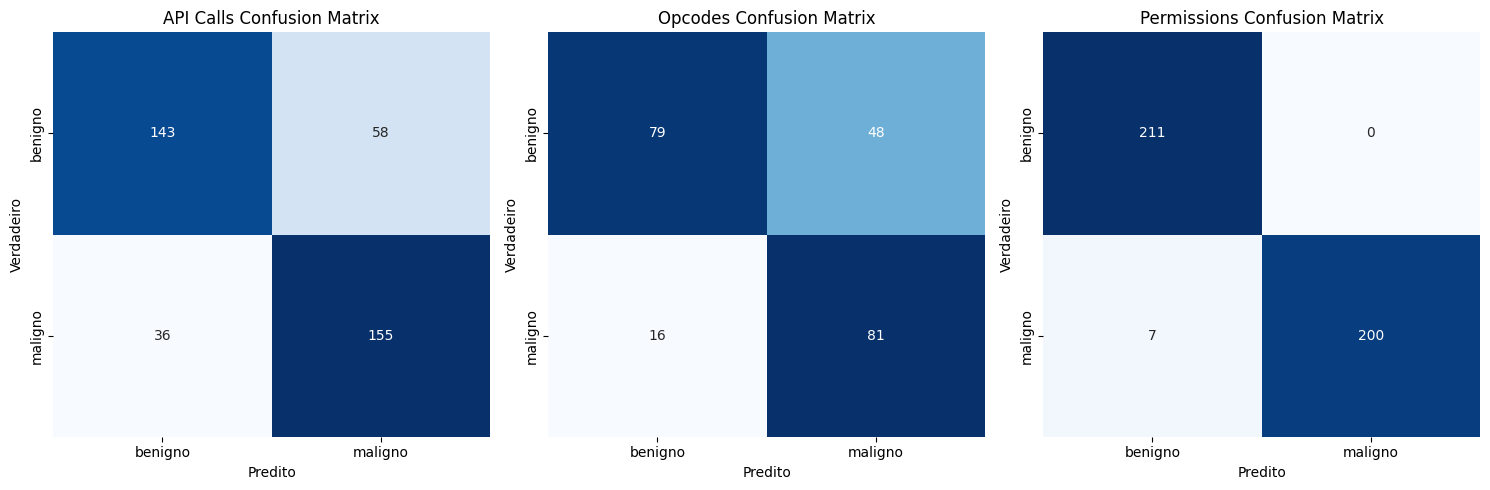

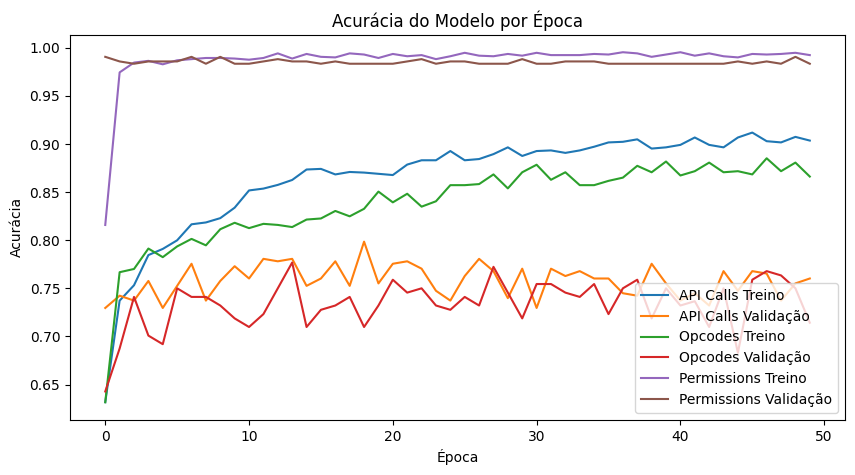

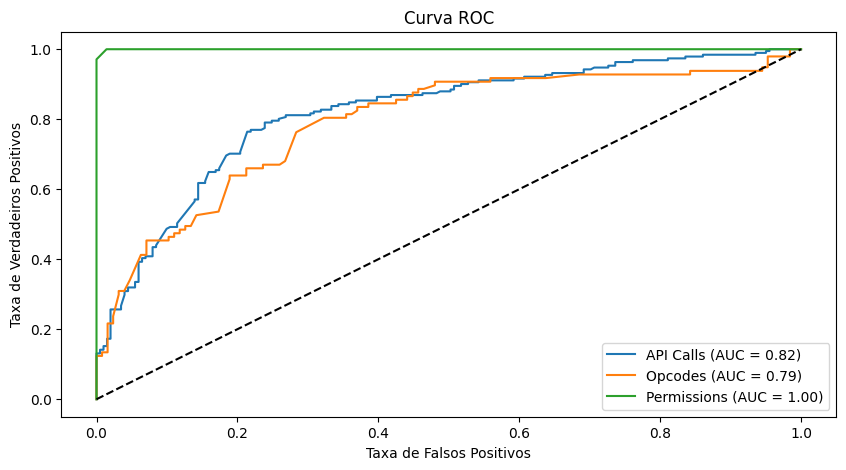

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# Função de callback para imprimir informações sobre o número de amostras
def on_epoch_end(epoch, logs):
    print(f"\nÉpoca {epoch + 1}:")
    print(f"Número de amostras no treino: {X_train.shape[0]}")
    print(f"Número de amostras no teste: {X_test.shape[0]}")

# Função para carregar e preparar os dados
def carregar_dados(csv_file_benign, csv_file_malign):
    num_cols_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
    num_cols_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', quoting=csv.QUOTE_NONE, on_bad_lines='skip').shape[1]
    max_num_cols = max(num_cols_benign, num_cols_malign)

    data_benign = pd.read_csv(csv_file_benign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')
    data_malign = pd.read_csv(csv_file_malign, encoding='ISO-8859-1', sep=';', names=range(max_num_cols), quoting=csv.QUOTE_NONE, on_bad_lines='warn')

    data_benign['classe'] = 'benigno'
    data_malign['classe'] = 'maligno'
    data_benign_downsampled = resample(data_benign, replace=False, n_samples=len(data_malign), random_state=42)
    data_full = pd.concat([data_benign_downsampled, data_malign], axis=0)

    X = data_full.iloc[:, :-1].apply(pd.to_numeric, errors='coerce').fillna(0)
    y = data_full.iloc[:, -1]

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    X = X.astype(np.float32)
    y = y.astype(np.int32)

    return X, y

# Função para criar e treinar o modelo MLP
def treinar_modelo(X, y, input_dim, dropout_rate=0.2, epochs=50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)

    model = Sequential([
        Dense(256, activation='sigmoid', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(256, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test), callbacks=[print_callback])

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    return y_test_classes, y_pred_classes, y_test, y_pred, model, history

dados = {
    'API Calls': ('api_calls_2b.csv', 'api_calls_2m.csv'),
    'Opcodes': ('opcodes_2b.csv', 'opcodes_2m.csv'),
    'Permissions': ('permissions_2b.csv', 'permissions_2m.csv')
}

classification_reports = []
confusion_matrices = []
histories = []
roc_curves = []

for nome, (csv_b, csv_m) in dados.items():
    X, y = carregar_dados(csv_b, csv_m)
    y_test_classes, y_pred_classes, y_test, y_pred, model, history = treinar_modelo(X, y, input_dim=X.shape[1], epochs=50)
    report = classification_report(y_test_classes, y_pred_classes, target_names=['benigno', 'maligno'])
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    classification_reports.append((nome, report))
    confusion_matrices.append((nome, conf_matrix))
    histories.append((nome, history))

    # Calcular a curva ROC e AUC para o modelo atual
    fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_curves.append((nome, fpr, tpr, roc_auc))

    model.save(f'MLP_{nome}.h5')
    print(f"Modelo salvo como 'MLP_{nome}.h5'")

# Exibir os relatórios de classificação
for model_name, report in classification_reports:
    print(f"\nRelatório de Classificação para {model_name}:\n{report}")

# Plotar as matrizes de confusão
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (model_name, conf_matrix) in zip(axes, confusion_matrices):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['benigno', 'maligno'], yticklabels=['benigno', 'maligno'], ax=ax)
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')

plt.tight_layout()
plt.show()

# Plotar os gráficos de precisão (acurácia) ao longo das épocas
plt.figure(figsize=(10, 5))
for model_name, history in histories:
    plt.plot(history.history['accuracy'], label=f'{model_name} Treino')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validação')
plt.title('Acurácia do Modelo por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotar as curvas ROC
plt.figure(figsize=(10, 5))
for model_name, fpr, tpr, roc_auc in roc_curves:
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal de chance
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.show()


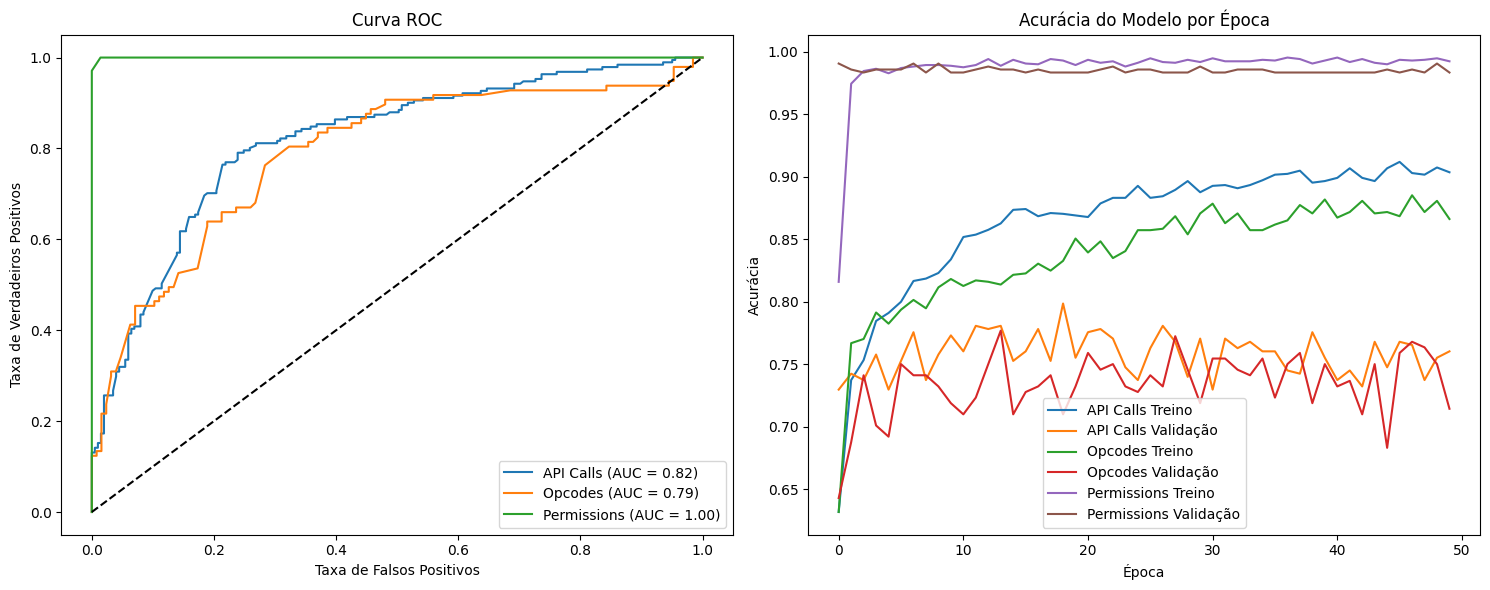

In [12]:
# Plotar os gráficos de ROC e Acurácia lado a lado (ROC à esquerda)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de Curvas ROC (à esquerda)
for model_name, fpr, tpr, roc_auc in roc_curves:
    ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], 'k--')  # Diagonal de chance
ax1.set_title('Curva ROC')
ax1.set_xlabel('Taxa de Falsos Positivos')
ax1.set_ylabel('Taxa de Verdadeiros Positivos')
ax1.legend(loc='lower right')

# Gráfico de Acurácia (à direita)
for model_name, history in histories:
    ax2.plot(history.history['accuracy'], label=f'{model_name} Treino')
    ax2.plot(history.history['val_accuracy'], label=f'{model_name} Validação')
ax2.set_title('Acurácia do Modelo por Época')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia')
ax2.legend()

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()


#Votacao

In [8]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Carregar os modelos Keras (.h5)
model_api = load_model('MLP_API.h5')
model_opcodes = load_model('MLP_Op.h5')
model_permissions = load_model('MLP_P.h5')

# Carregar e concatenar as bases de dados benignas e malignas com o rótulo verdadeiro
api_calls_b = pd.read_csv('api_calls_2b.csv', sep=';', on_bad_lines='skip')
api_calls_b['true_label'] = 0  # Benigno

api_calls_m = pd.read_csv('api_calls_2m.csv', sep=';', on_bad_lines='skip')
api_calls_m['true_label'] = 1  # Maligno

api_calls = pd.concat([api_calls_b, api_calls_m], ignore_index=True)

opcodes_b = pd.read_csv('opcodes_2b.csv', sep=';', on_bad_lines='skip')
opcodes_b['true_label'] = 0  # Benigno

opcodes_m = pd.read_csv('opcodes_2m.csv', sep=';', on_bad_lines='skip')
opcodes_m['true_label'] = 1  # Maligno

opcodes = pd.concat([opcodes_b, opcodes_m], ignore_index=True)

permissions_b = pd.read_csv('permissions_2b.csv', sep=';', on_bad_lines='skip')
permissions_b['true_label'] = 0  # Benigno

permissions_m = pd.read_csv('permissions_2m.csv', sep=';', on_bad_lines='skip')
permissions_m['true_label'] = 1  # Maligno

permissions = pd.concat([permissions_b, permissions_m], ignore_index=True)

# Substituir os valores NaN por 0.0 nas bases de dados
api_calls = api_calls.fillna(0.0)
opcodes = opcodes.fillna(0.0)
permissions = permissions.fillna(0.0)

# Remover a coluna 'Nome do Arquivo' antes de realizar as predições
api_calls_aligned = api_calls.drop(columns=['Nome do Arquivo'], errors='ignore')
opcodes_aligned = opcodes.drop(columns=['Nome do Arquivo'], errors='ignore')
permissions_aligned = permissions.drop(columns=['Nome do Arquivo'], errors='ignore')

# Função para ajustar o input shape
def adjust_input_shape(data, model):
    input_shape = model.input_shape[1]  # Pega o número de features esperado
    data_shape = data.shape[1]          # Número de features do dataframe

    if data_shape < input_shape:
        # Adiciona colunas com zeros para aumentar o número de features
        data = np.pad(data, ((0, 0), (0, input_shape - data_shape)), mode='constant', constant_values=0)
    elif data_shape > input_shape:
        # Reduz o número de features para o input shape esperado
        data = data[:, :input_shape]

    return data

# Converter os DataFrames para arrays NumPy e ajustar o shape
api_calls_aligned = adjust_input_shape(np.array(api_calls_aligned), model_api)
opcodes_aligned = adjust_input_shape(np.array(opcodes_aligned), model_opcodes)
permissions_aligned = adjust_input_shape(np.array(permissions_aligned), model_permissions)

# Realizar as predições com os modelos Keras
api_calls['prediction_api'] = np.argmax(model_api.predict(api_calls_aligned), axis=1)
opcodes['prediction_opcodes'] = np.argmax(model_opcodes.predict(opcodes_aligned), axis=1)
permissions['prediction_permissions'] = np.argmax(model_permissions.predict(permissions_aligned), axis=1)

# Juntar todas as predições com o respectivo nome do arquivo e rótulo verdadeiro
df_predictions = pd.DataFrame({
    'Nome do Arquivo': api_calls['Nome do Arquivo'],
    'true_label': api_calls['true_label'],
    'prediction_api': api_calls['prediction_api'],
    'prediction_opcodes': opcodes['prediction_opcodes'],
    'prediction_permissions': permissions['prediction_permissions']
})

# Votação final: se a soma das predições for maior ou igual a 2, o apk é maligno (1), caso contrário, é benigno (0)
df_predictions['final_prediction'] = df_predictions[['prediction_api', 'prediction_opcodes', 'prediction_permissions']].sum(axis=1).apply(lambda x: 1 if x >= 2 else 0)

# Salvar o resultado final
df_predictions.to_csv('final_predictions_Keras.csv', index=False, sep=';')

print("Predições salvas com sucesso!")


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

<ipython-input-8-270366986dd2>:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  api_calls['prediction_api'] = np.argmax(model_api.predict(api_calls_aligned), axis=1)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
28/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

<ipython-input-8-270366986dd2>:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  opcodes['prediction_opcodes'] = np.argmax(model_opcodes.predict(opcodes_aligned), axis=1)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predições salvas com sucesso!


<ipython-input-8-270366986dd2>:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  permissions['prediction_permissions'] = np.argmax(model_permissions.predict(permissions_aligned), axis=1)


Contagem da Porcentagem

In [9]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Carregar o arquivo gerado de predições
df_predictions = pd.read_csv('final_predictions_Keras.csv', sep=';')

# Verificar o conteúdo do DataFrame para identificar onde estão os valores NaN
print("Visualização das primeiras linhas do DataFrame:")
print(df_predictions.head())

# Verificar os nomes das colunas para assegurar que estamos usando a coluna correta
print("\nNomes das colunas no DataFrame:")
print(df_predictions.columns)

# Substitua 'Nome da coluna do rótulo verdadeiro' pelo nome exato do rótulo verdadeiro, se necessário
# Exemplo: se a coluna de rótulos é chamada 'true_label', faça a seguinte modificação:
y_true = df_predictions['true_label'].fillna(0).astype(int)

# Pegando a coluna 'final_prediction', que é a predição final
y_pred = df_predictions['final_prediction']

# Calcular a acurácia, verificando se não há NaN em y_true ou y_pred
if y_true.isnull().any() or y_pred.isnull().any():
    print("Há valores NaN em y_true ou y_pred.")
else:
    # Calcular e exibir a acurácia se não houver NaNs
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Acurácia das predições: {accuracy * 100:.2f}%')


Visualização das primeiras linhas do DataFrame:
                                     Nome do Arquivo  true_label  \
0  737CF9D5F9C8358912899B8456A4218F715B51751447B7...         0.0   
1  7404EA1DB4AD8F4A437230A0BDD41589602E101C534664...         0.0   
2  7439EF696B21CDED804B162C2CE35F487DBC0D93FC3425...         0.0   
3  744A596B80E02A2FA07C62204EBC864BEA2791AADABF67...         0.0   
4  746B7F67C877133ECE928D7876C849A958623957FF1CCB...         0.0   

   prediction_api  prediction_opcodes  prediction_permissions  \
0             0.0                 1.0                       1   
1             0.0                 1.0                       1   
2             0.0                 1.0                       1   
3             0.0                 1.0                       0   
4             0.0                 1.0                       1   

   final_prediction  
0                 1  
1                 1  
2                 1  
3                 0  
4                 1  

Nomes das colunas n

In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Carregar o arquivo gerado de predições
df_predictions = pd.read_csv('final_predictions_Keras.csv', sep=';')

# Verificar o conteúdo do DataFrame para identificar onde estão os valores NaN
print("Visualização das primeiras linhas do DataFrame:")
print(df_predictions.head())

# Verificar os nomes das colunas para assegurar que estamos usando a coluna correta
print("\nNomes das colunas no DataFrame:")
print(df_predictions.columns)

# Remover as linhas que têm valores NaN nas colunas 'true_label'
df_predictions.dropna(subset=['true_label'], inplace=True)

# Agora podemos converter a coluna 'true_label' para inteiros sem erros
y_true = df_predictions['true_label'].astype(int)

# Pegando a coluna 'final_prediction', que é a predição final
y_pred = df_predictions['final_prediction']

# Calcular a acurácia, verificando se não há NaN em y_true ou y_pred
if y_true.isnull().any() or y_pred.isnull().any():
    print("Há valores NaN em y_true ou y_pred.")
else:
    # Calcular e exibir a acurácia se não houver NaNs
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Acurácia das predições: {accuracy * 100:.2f}%')


Visualização das primeiras linhas do DataFrame:
                                     Nome do Arquivo  true_label  \
0  737CF9D5F9C8358912899B8456A4218F715B51751447B7...         0.0   
1  7404EA1DB4AD8F4A437230A0BDD41589602E101C534664...         0.0   
2  7439EF696B21CDED804B162C2CE35F487DBC0D93FC3425...         0.0   
3  744A596B80E02A2FA07C62204EBC864BEA2791AADABF67...         0.0   
4  746B7F67C877133ECE928D7876C849A958623957FF1CCB...         0.0   

   prediction_api  prediction_opcodes  prediction_permissions  \
0             0.0                 1.0                       1   
1             0.0                 1.0                       1   
2             0.0                 1.0                       1   
3             0.0                 1.0                       0   
4             0.0                 1.0                       1   

   final_prediction  
0                 1  
1                 1  
2                 1  
3                 0  
4                 1  

Nomes das colunas n